In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data preprocess

In [2]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
import pickle as pkl
import numpy as np

In [4]:
with open("/content/drive/MyDrive/cmn-eng/eng-cn.pkl", "rb") as f:
    seq_pairs = pkl.load(f)

In [5]:
src_sentences = [pair[0] for pair in seq_pairs[:10000]]    #RAM有限，所以只取數據集中一萬筆數據做訓練
tgt_sentences = [pair[1] for pair in seq_pairs[:10000]]

In [6]:
src_sentences[:5]

['<START> hi . <END>',
 '<START> hi . <END>',
 '<START> run . <END>',
 '<START> stop ! <END>',
 '<START> wait ! <END>']

In [7]:
tgt_sentences[:5]

['<START> 嗨 。 <END>',
 '<START> 你 好 。 <END>',
 '<START> 你 用 跑 的 。 <END>',
 '<START> 住 手 ！ <END>',
 '<START> 等 等 ！ <END>']

In [8]:
def create_tokeniser(sentences):
    # create a tokeniser specific to texts
    tokeniser = Tokenizer(filters = ' ')
    tokeniser.fit_on_texts(sentences)
    # 預覽前 3 個data及label
    for i in range(3):
        print("original: {} - word tokenised: {}".format(sentences[i], tokeniser.texts_to_sequences(sentences)[i]))

    return tokeniser.texts_to_sequences(sentences), tokeniser

# word tokenise source and target sentences
src_word_tokenised, src_tokeniser = create_tokeniser(src_sentences)
tgt_word_tokenised, tgt_tokeniser = create_tokeniser(tgt_sentences)

original: <START> hi . <END> - word tokenised: [1, 730, 3, 2]
original: <START> hi . <END> - word tokenised: [1, 730, 3, 2]
original: <START> run . <END> - word tokenised: [1, 322, 3, 2]
original: <START> 嗨 。 <END> - word tokenised: [1, 1284, 3, 2]
original: <START> 你 好 。 <END> - word tokenised: [1, 6, 25, 3, 2]
original: <START> 你 用 跑 的 。 <END> - word tokenised: [1, 6, 138, 268, 7, 3, 2]


In [9]:
# source and target vocabulary dictionaries
src_vocab_dict = src_tokeniser.word_index  #每個單詞的token ID
tgt_vocab_dict = tgt_tokeniser.word_index

src_vocab_size = len(src_vocab_dict) + 1 # 3080 tokens in total
tgt_vocab_size = len(tgt_vocab_dict) + 1 # 2455 tokens in total

In [10]:
tgt_vocab_size

2455

In [11]:
src_max_seq_length = len(max(src_word_tokenised, key = len)) # 11  #數據中最長句子長度
tgt_max_seq_length = len(max(tgt_word_tokenised, key = len)) # 22  #標籤中最長句子長度

In [12]:
tgt_max_seq_length

22

In [13]:
#讓數據及標籤標準化，長度相等，用0填充
src_sentences_padded = pad_sequences(src_word_tokenised, maxlen = src_max_seq_length, padding = "post")  # shape: (10000, 11)
tgt_sentences_padded = pad_sequences(tgt_word_tokenised, maxlen = tgt_max_seq_length, padding = "post")  # shape: (10000, 22)

# increase 1 dimension
src_sentences_padded = src_sentences_padded.reshape(*src_sentences_padded.shape, 1) # shape: (10000, 11, 1)
tgt_sentences_padded = tgt_sentences_padded.reshape(*tgt_sentences_padded.shape, 1) # shape: (10000, 22, 1)

In [14]:
tgt_sentences_padded.shape

(10000, 22, 1)

In [15]:
def encode_input_sequences(tokeniser, max_seq_length, sentences):
    """
    Label encode every sentences to create features X
    """
    # label encode every sentences
    sentences_le = tokeniser.texts_to_sequences(sentences)
    # pad sequences with zeros at the end
    X = pad_sequences(sentences_le, maxlen = max_seq_length, padding = "post")
    return X


def encode_output_labels(sequences, vocab_size):
    """
    One-hot encode target sequences to create labels y
    """
    y_list = []
    for seq in sequences:
        # one-hot encode each sentence
        oh_encoded = to_categorical(seq, num_classes = vocab_size)
        y_list.append(oh_encoded)
    y = np.array(y_list, dtype = np.float32)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# create encoder inputs, decoder inputs and decoder outputs    #n_samples=10000
enc_inputs = encode_input_sequences(src_tokeniser, src_max_seq_length, src_sentences) # shape: (n_samples=10000, src_max_seq_length, 1)
dec_inputs = encode_input_sequences(tgt_tokeniser, tgt_max_seq_length, tgt_sentences) # shape: (n_samples, tgt_max_seq_length, 1)
dec_outputs = encode_input_sequences(tgt_tokeniser, tgt_max_seq_length, tgt_sentences)
dec_outputs = encode_output_labels(dec_outputs, tgt_vocab_size) # shape: (n_samples, tgt_max_seq_length, tgt_vocab_size )

In [16]:
dec_outputs[0].shape

(22, 2455)

### Save dataset

In [17]:
# save required data to a compressed file
'''
np.savez_compressed("/content/drive/MyDrive/cmn-eng/eng-cn_data.npz", enc_inputs = enc_inputs, dec_inputs = dec_inputs, dec_outputs = dec_outputs, src_vocab_size = src_vocab_size)
'''

'\nnp.savez_compressed("/content/drive/MyDrive/cmn-eng/eng-cn_data.npz", enc_inputs = enc_inputs, dec_inputs = dec_inputs, dec_outputs = dec_outputs, src_vocab_size = src_vocab_size)\n'

### Create train data and test data

In [18]:
data = np.load("/content/drive/MyDrive/cmn-eng/eng-cn_data.npz")
print(data.files) # ['enc_inputs', 'dec_inputs', 'dec_outputs', 'src_vocab_size']

# Extract our desired data
enc_inputs = data["enc_inputs"]
dec_inputs = data["dec_inputs"]
dec_outputs = data["dec_outputs"]
src_vocab_size = data["src_vocab_size"].item(0)  #type is int 3080

['enc_inputs', 'dec_inputs', 'dec_outputs', 'src_vocab_size']


In [19]:
# shuffle X and y in unision
shuffler = np.random.permutation(enc_inputs.shape[0])
enc_inputs = enc_inputs[shuffler]
dec_inputs = dec_inputs[shuffler]
dec_outputs = dec_outputs[shuffler]

In [20]:
from sklearn.model_selection import train_test_split


# prepare training and test data
test_ratio = .2
enc_inputs_train, enc_inputs_test = train_test_split(enc_inputs, test_size = test_ratio, shuffle = False)
dec_inputs_train, dec_inputs_test = train_test_split(dec_inputs, test_size = test_ratio, shuffle = False)
y_train, y_test = train_test_split(dec_outputs, test_size = test_ratio, shuffle = False)
X_train = [enc_inputs_train, dec_inputs_train]
X_test = [enc_inputs_test, dec_inputs_test]

### Create Model

In [21]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Activation, dot, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [23]:
src_max_seq_length = enc_inputs.shape[1]
tgt_max_seq_length = dec_outputs.shape[1]
tgt_vocab_size = dec_outputs.shape[2]

In [49]:
# hyperparameters
src_wordEmbed_dim = 96
tgt_wordEmbed_dim = 100
latent_dim = 256

def build_seq2seq(src_max_seq_length, src_vocab_size, src_wordEmbed_dim, tgt_max_seq_length, tgt_vocab_size, tgt_wordEmbed_dim, latent_dim, model_name = None):
    """
    Builda an LSTM seq2seq model with Luong attention
    """
    # Build an encoder
    enc_inputs = Input(shape = (src_max_seq_length, ))
    vectors = Embedding(input_dim = src_vocab_size, output_dim = src_wordEmbed_dim, name = "embedding_enc")(enc_inputs)
    enc_outputs_1, enc_h1, enc_c1 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "1st_layer_enc_LSTM")(vectors)
    enc_outputs_2, enc_h2, enc_c2 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "2nd_layer_enc_LSTM")(enc_outputs_1)
    enc_states = [enc_h1, enc_c1, enc_h2, enc_c2]

    # Build a decoder
    dec_inputs = Input(shape = (tgt_max_seq_length, ))
    vectors = Embedding(input_dim = tgt_vocab_size, output_dim = tgt_wordEmbed_dim, name = "embedding_dec")(dec_inputs)
    dec_outputs_1, dec_h1, dec_c1 = LSTM(latent_dim, return_sequences = True, return_state = True, name = "1st_layer_dec_LSTM")(vectors, initial_state = [enc_h1, enc_c1])
    dec_outputs_2 = LSTM(latent_dim, return_sequences = True, return_state = False, name = "2nd_layer_dec_LSTM")(dec_outputs_1, initial_state = [enc_h2, enc_c2])

    # evaluate attention score
    attention_scores = dot([dec_outputs_2, enc_outputs_2], axes = [2, 2])
    attenton_weights = Activation("softmax")(attention_scores)
    context_vec = dot([attenton_weights, enc_outputs_2], axes = [2, 1])
    ht_context_vec = concatenate([context_vec, dec_outputs_2], name = "concatentated_vector")
    attention_vec = Dense(latent_dim, use_bias = False, activation = "tanh", name = "attentional_vector")(ht_context_vec)
    logits = TimeDistributed(Dense(tgt_vocab_size))(attention_vec)
    dec_outputs_final = Activation("softmax", name = "softmax")(logits)

    # integrate as a model
    model = Model([enc_inputs, dec_inputs], dec_outputs_final, name = model_name)
    # compile model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
        loss = tf.keras.losses.CategoricalCrossentropy(),   #metrics=[masked_acc, masked_loss]
        metrics = [tf.keras.metrics.CategoricalAccuracy(name='acc')]
    )
    return model

# build our seq2seq model
eng_cn_translator = build_seq2seq(
    src_max_seq_length = src_max_seq_length,
    src_vocab_size = src_vocab_size,
    src_wordEmbed_dim = src_wordEmbed_dim,
    tgt_max_seq_length = tgt_max_seq_length,
    tgt_vocab_size = tgt_vocab_size,
    tgt_wordEmbed_dim = tgt_wordEmbed_dim,
    latent_dim = latent_dim,
    model_name = "eng-cn_translator_v1"
    )
eng_cn_translator.summary()

Model: "eng-cn_translator_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 11)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 22)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_enc (Embedding) │ (None, 11, 96)         │        295,680 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_dec (Embedding) │ (None, 22, 100)        │        245,500 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1st_layer_enc_LSTM (LSTM) │ [(None, 11, 256),      │        361,472 │ embedding_enc[0][0]    │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1st_layer_dec_LSTM (LSTM) │ [(None, 22, 256),      │        365,568 │ embedding_dec[0][0],   │
│                           │ (None, 256), (None,    │                │ 1st_layer_enc_LSTM[0]… │
│                           │ 256)]                  │                │ 1st_layer_enc_LSTM[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2nd_layer_enc_LSTM (LSTM) │ [(None, 11, 256),      │        525,312 │ 1st_layer_enc_LSTM[0]… │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2nd_layer_dec_LSTM (LSTM) │ (None, 22, 256)        │        525,312 │ 1st_layer_dec_LSTM[0]… │
│                           │                        │                │ 2nd_layer_enc_LSTM[0]… │
│                           │                        │                │ 2nd_layer_enc_LSTM[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_2 (Dot)               │ (None, 22, 11)         │              0 │ 2nd_layer_dec_LSTM[0]… │
│                           │                        │                │ 2nd_layer_enc_LSTM[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 22, 11)         │              0 │ dot_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_3 (Dot)               │ (None, 22, 256)        │              0 │ activation_1[0][0],    │
│                           │                        │                │ 2nd_layer_enc_LSTM[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatentated_vector      │ (None, 22, 512)        │              0 │ dot_3[0][0],           │
│ (Concatenate)             │                        │                │ 2nd_layer_dec_LSTM[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attentional_vector        │ (None, 22, 256)        │        131,072 │ concatentated_vector[… │
│ (Dense)              

 Total params: 3,080,851 (11.75 MB)

 Trainable params: 3,080,851 (11.75 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# save model and its weights at a certain frequency
ckpt = ModelCheckpoint(
    filepath = "/content/drive/MyDrive/Colab Notebooks/eng-cmn project/Save_model/eng-cn_translator_v2.keras",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    save_freq = "epoch",
    mode = "min",
)
es = EarlyStopping(
    monitor = "loss",
    mode = "min",
    patience = 10
)



In [26]:
# train model
train_hist = eng_cn_translator.fit(
                            X_train,
                            y_train,
                            batch_size = 64,
                            epochs = 200,
                            validation_split = .2,
                            verbose = 2,
                            callbacks = [es, ckpt]
                        )


Epoch 1/200

Epoch 1: val_loss improved from inf to 1.80028, saving model to /content/drive/MyDrive/Colab Notebooks/eng-cmn project/Save_model/eng-cn_translator_v2.keras
100/100 - 13s - 127ms/step - acc: 0.6319 - loss: 2.5827 - val_acc: 0.7205 - val_loss: 1.8003
Epoch 2/200

Epoch 2: val_loss improved from 1.80028 to 1.46113, saving model to /content/drive/MyDrive/Colab Notebooks/eng-cmn project/Save_model/eng-cn_translator_v2.keras
100/100 - 4s - 36ms/step - acc: 0.7353 - loss: 1.6030 - val_acc: 0.7387 - val_loss: 1.4611
Epoch 3/200

Epoch 3: val_loss improved from 1.46113 to 1.25333, saving model to /content/drive/MyDrive/Colab Notebooks/eng-cmn project/Save_model/eng-cn_translator_v2.keras
100/100 - 5s - 51ms/step - acc: 0.7626 - loss: 1.3209 - val_acc: 0.7702 - val_loss: 1.2533
Epoch 4/200

Epoch 4: val_loss improved from 1.25333 to 1.13579, saving model to /content/drive/MyDrive/Colab Notebooks/eng-cmn project/Save_model/eng-cn_translator_v2.keras
100/100 - 5s - 49ms/step - acc: 0

training history have info: dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


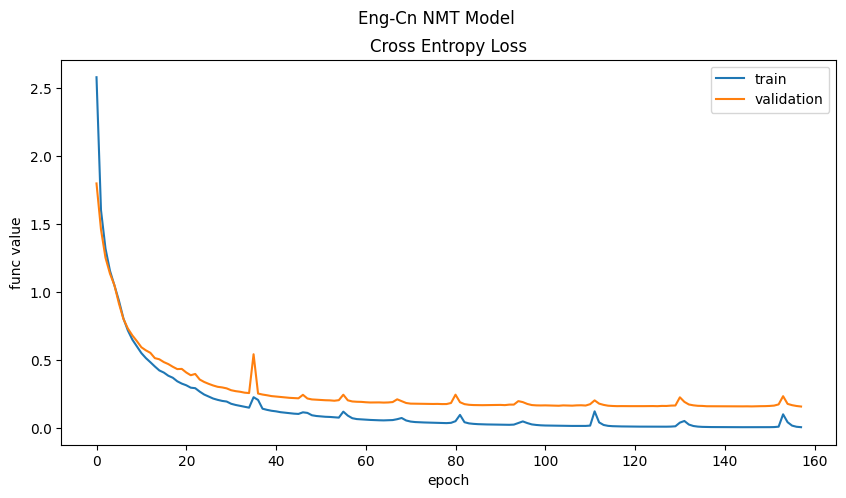

In [27]:
# preview training history
print("training history have info: {}".format(train_hist.history.keys())) # ['loss', 'val_loss']
fig, ax = plt.subplots(figsize = (10, 5))
fig.suptitle("Eng-Cn NMT Model")
ax.set_title("Cross Entropy Loss")
ax.plot(train_hist.history["loss"], label = "train")
ax.plot(train_hist.history["val_loss"], label = "validation")
ax.set_xlabel("epoch")
ax.set_ylabel("func value")
ax.legend()
plt.show()

training history have info: dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


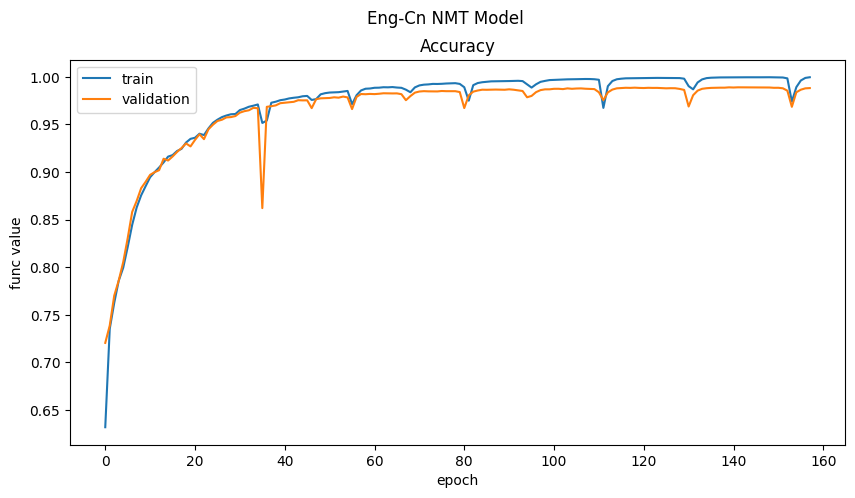

In [39]:
# preview training history
print("training history have info: {}".format(train_hist.history.keys())) # ['loss', 'val_loss']
fig, ax = plt.subplots(figsize = (10, 5))
fig.suptitle("Eng-Cn NMT Model")
ax.set_title("Accuracy")
ax.plot(train_hist.history["acc"], label = "train")
ax.plot(train_hist.history["val_acc"], label = "validation")
ax.set_xlabel("epoch")
ax.set_ylabel("func value")
ax.legend()
plt.show()

### Predict the model

In [3]:
from tensorflow.keras.models import load_model

# load pre-trained model
eng_cn_translator = load_model('/content/drive/MyDrive/Colab Notebooks/eng-cmn project/Save_model/eng-cn_translator_v2.keras')

In [41]:
# predict model
trans_seqs = eng_cn_translator.predict(
                X_test,
                batch_size = 60,
                verbose = 1,
                #use_multiprocessing = True
            )
print(trans_seqs[0])

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
[[5.6305333e-10 9.9999881e-01 5.3494141e-12 ... 5.9931737e-16
  5.8957071e-18 1.2679365e-16]
 [3.5275370e-18 1.3943913e-13 1.9317012e-09 ... 2.2145543e-09
  1.1548756e-06 1.6208865e-08]
 [4.0449192e-17 1.7044137e-13 6.5134662e-09 ... 1.8177597e-07
  3.6556280e-08 2.6227715e-05]
 ...
 [9.9999774e-01 2.2299483e-08 5.8051535e-07 ... 5.9325652e-14
  6.7198902e-17 1.7410468e-12]
 [9.9999785e-01 2.2233571e-08 5.8436473e-07 ... 5.8821891e-14
  6.7052180e-17 1.7401274e-12]
 [9.9999785e-01 2.2216955e-08 5.8502553e-07 ... 5.8711709e-14
  6.7017406e-17 1.7397324e-12]]


In [42]:
# 使用 zip 函數對調
reverse_src_vocab_dict = dict(zip(src_vocab_dict.values(), src_vocab_dict.keys()))
reverse_tgt_vocab_dict = dict(zip(tgt_vocab_dict.values(), tgt_vocab_dict.keys()))

In [43]:
def pred_seq(model, single_seq_pair, reverse_tgt_vocab_dict):
    """
    Predicts a single sentence
    ---------------------------
    single_seq_pair:
        sequence pair that is made up of only one source sequence and one target sequence [(src_max_seq_length, ), (tgt_max_seq_length, )]
        type: list of NumPy arrays
    """
    # print("raw prediction: ", model.predict(single_seq_pair))
    # model gives a one-hot encoded array
    pred = model.predict(single_seq_pair)[0]
    # turns into label encoded array (word_id's)
    pred_le = [np.argmax(oneHot_vec) for oneHot_vec in pred]
    # print("pred_le: ", pred_le)
    pred_tokens = []
    for id in pred_le:
        try:
            word = reverse_tgt_vocab_dict[id]
            pred_tokens.append(word)
        except KeyError:
            break
    return ' '.join(pred_tokens)



In [44]:
# predict the 5th sentence in X_test
i = 6

# ground truth sentences

print("actual source sentence: {}".format([reverse_src_vocab_dict[id] for id in X_test[0][i] if id != 0]))
print("actual target sentence: {}".format([reverse_tgt_vocab_dict[id] for id in X_test[1][i] if id != 0]))

actual source sentence: ['<start>', 'you', "'re", 'babbling', '.', '<end>']
actual target sentence: ['<start>', '你', '说', '话', '含', '糊', '不', '清', '。', '<end>']


In [45]:
# 選擇你想要預測的句子索引
i = 6

# 準備 source 和 target 對的輸入數據
single_seq_pair = [X_test[0][i:i+1], X_test[1][i:i+1]]  # 包含單個句子的 (source, target) pair


In [46]:
predicted_sentence = pred_seq(eng_cn_translator, single_seq_pair, reverse_tgt_vocab_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [47]:
predicted_sentence

'<start> 你 说 话 費 坡 不 清 。 <end>'

In [48]:
ref = 'https://ithelp.ithome.com.tw/articles/10279884'